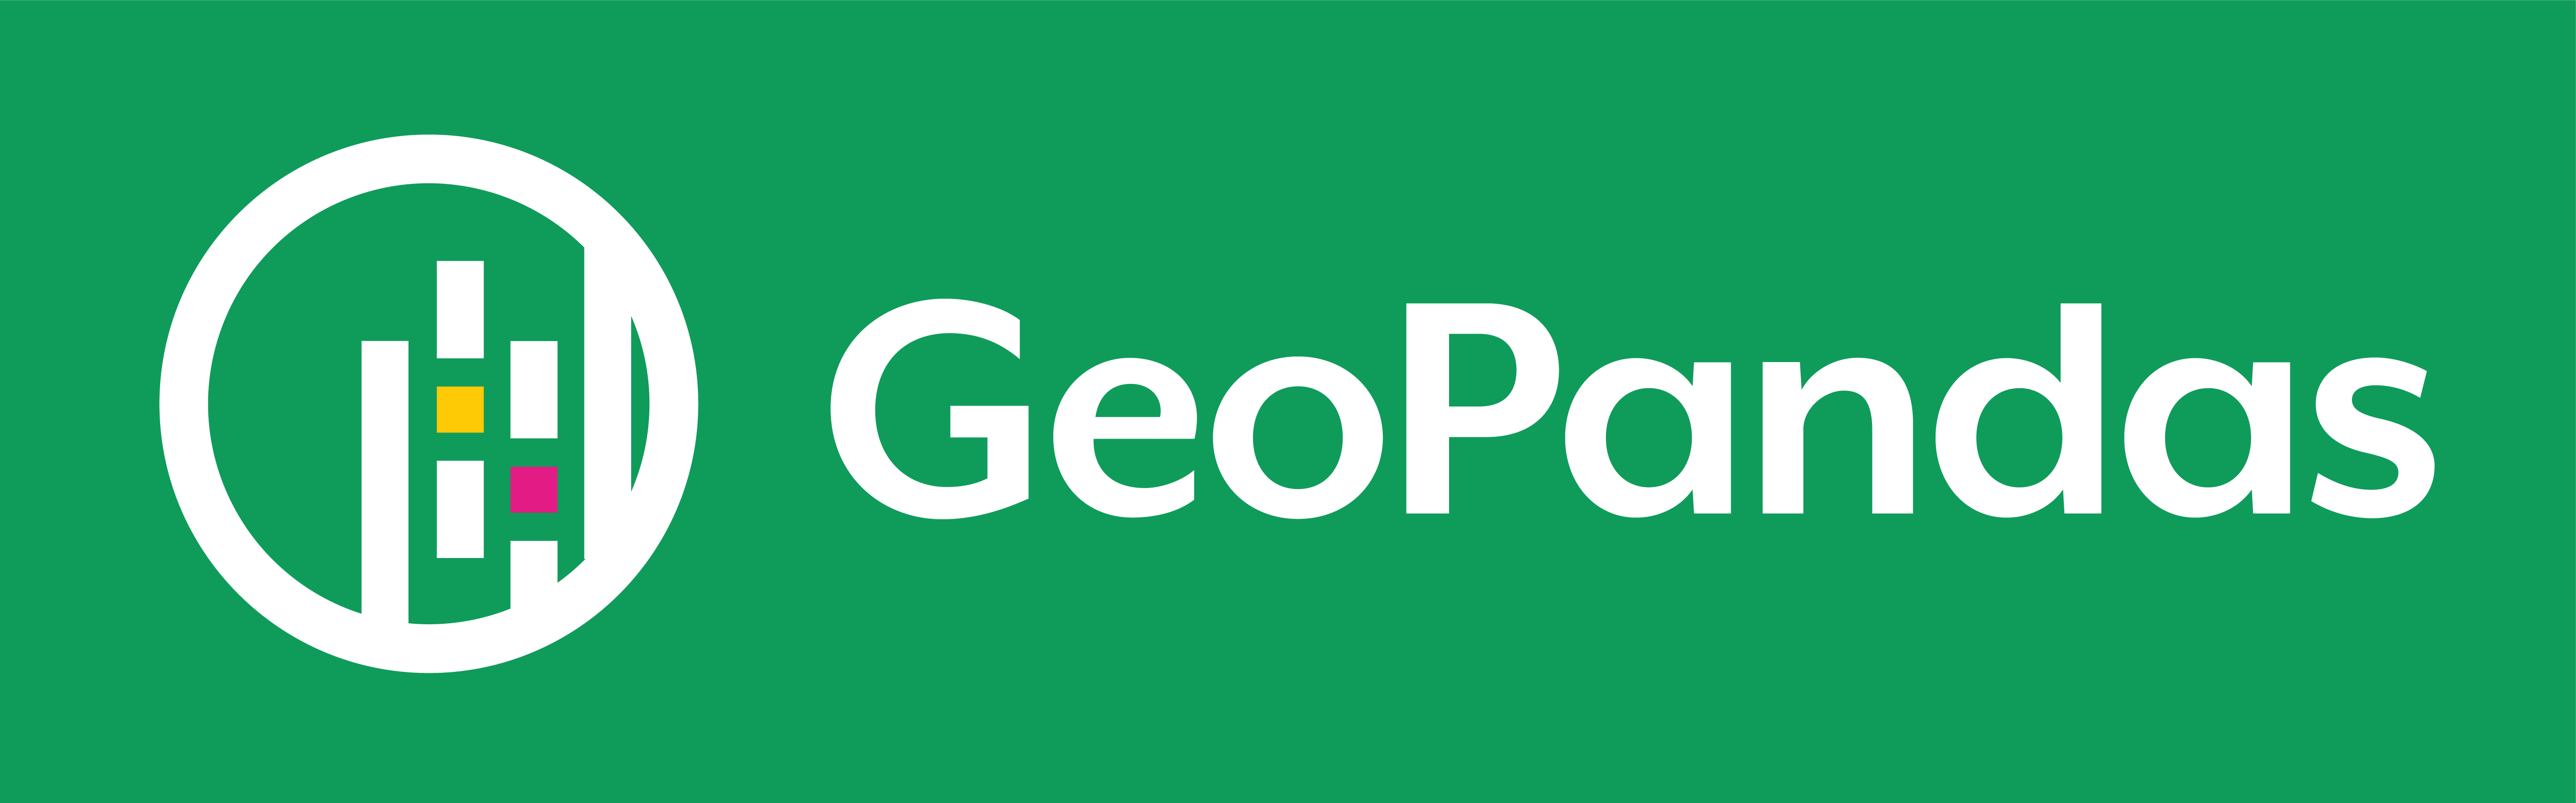

### 0. Introduction


##### 0.1 What is GeoPandas? Why is GeoPandas? 

Geopandas is an extension of the [pandas](https://pandas.pydata.org/) library's datatypes that allows spatial operations on geometric types, in order to make working with geospatial data in python easier. It enables to perform operations in python that would usually require a spatial database such as PostGIS. 

It uses [shapely](https://shapely.readthedocs.io/en/stable/) (a python package for manipulation and analysis of planar geometric objects, deployed alongside the geometry library [GEOS](https://libgeos.org/)). Furthermore, it uses [pyogrio](https://pyogrio.readthedocs.io/en/latest/) (used to provide acess to [GDAL/OGR](https://gdal.org/en/latest/drivers/vector/index.html) vector data sources). And finally, it uses the well known [matplotlib](http://matplotlib.org/) for plotting. 



### 1. Problems tackled

##### 1.1 Fragmented Ecosystem

Without GeoPandas (which will be referred to as gpd from now) working with gespatial data in Python could be fragmented and cumbersome. Suppose that we have some spacial data, to properly work on it we wold have to utilize the following stack: 
- Shapely: For geometry operations 
- Fiona: For reading Shapefiles and/ or GeoJSON 
- Matplotlib: For visualization 
- Pandas: For manipulation of table data 

The following problem is solved via the import of a single, cohesive library. 



##### 1.2 Database dependency

Simple spacial queries such as ("all stores within 1km of subway stations") requires setting up some SQL DB and managing database connections. 

Which is aliviated via an existing in-memory spatial database in gpd, that looks something like this when applied: 

```python

gdf = gpd.read_file('cities.shp')
# CRS is automatically tracked 
print(f"CRS: {gdf.crs}")  
gdf_proj = gdf.to_crs('EPSG:32633')
```

We esentially bring a POSTGIS-like functionality to Python's memory space. Among these we can point out: 
1. Spatial indexing & queries 
2. Spatial operations & functions
3. Spatial relationships 
4. Spatial Joins & overlays 
5. Coordinate reference systems.

Which while less powerful overall than those in POSTGIS, the gpd approach to them are more RAM friendly. 

##### 1.3 Tabular-Spatial Disconnect

Attributes (in pandas) and geometries (in shapely) are separate entities. Merging such things requires manual alignment, which is both risky and somewhat cumbersome. Gpd allows us to unify such structure. 


##### 1.4  Spatial intelligence in DataFrames
Pandas DataFrames do not inherently support spatial relationships, as they are primarly designed for general data manipulation, at least not without importing the Spatially Enabled DataFrame, that can be read about [here](https://developers.arcgis.com/python/latest/guide/introduction-to-the-spatially-enabled-dataframe/) and is out of the scope of this report. 

As a result you couldn't simply filer by location, perform spatial joins or calculate geographic properties. To solve the following problem gpd introduces spatial-aware DataFrame methods, which allow every DataFrame operation to understand the spatial context now. 








##### 1.5 Coordination problems

Coordinate systems could be easily lost during processing, leading to data being in wrong locations and inaccurate meaurements. Gpd solves this by making all of the CRS metadata follow data through all transformations, ensuring accurancy.

This, however, comes with its own edge cases;
- New geometry columns created via operations like `.centroid`, `.buffer()`, or `.intersection()` don't automatically inherit CRS from parent geometries
- DataFrame operations that drop or modify the geometry column may inadvertently strip CRS metadata
- Aggregation using standard pandas `.groupby().agg()` methods returns results without CRS, unlike `.dissolve()` which preserves it
- Mixed CRS operations between GeoDataFrames fail unless explicitly aligned with `.to_crs()`
- File format constraints: KML/KMZ exports always use EPSG:4326, potentially losing original CRS; shapefiles depend on separate .prj files that can be lost in transfer
- 3D data: Converting from 3D to 2D CRS silently drops elevation (Z-values)
- Performance: Repeated `.to_crs()` calls will create full geometry copies, impacting memory and speed with large datasets

Thus there are certain best practices recommended to be used when working with gpd
1. Verify CRS after operations: `assert gdf.crs is not None`
2. Project to appropriate local CRS before measurements (never measure in EPSG:4326)
3. Store original CRS when transforming: `original_crs = gdf.crs`
4. Use `.set_crs()` for data without CRS, not `.crs =` assignment
5. Check CRS compatibility before spatial operations between datasets

#### Installation and environment setup

In [4]:
# requied libraries 

# pip install geopandas 

In [ ]:
import geopandas as gpd


### 2. API

All of the classes and functions exposed in `geopandas.*` and those listed are public. 

##### 2.1 GeoSeries

**Constructor**

`GeoSeries([data, index, crs])` is a Series object desinged to store shapely geometry objects. This is the starting point for working with spatial data in gps. 

Now we will introduce some points, polygons and a linestring to connect the points. 

In [31]:
points_gs = gpd.GeoSeries.from_wkt([
    'POINT (0 0)',      
    'POINT (2 2)',      
    'POINT (4 0)'       
])

polys_gs = gpd.GeoSeries.from_wkt([
    'POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))',      
    'POLYGON ((2 2, 4 2, 4 4, 2 4, 2 2))'       
])

line_gs = gpd.GeoSeries.from_wkt(['LINESTRING (0 0, 2 2, 4 0)'])

print(f"Points: {points_gs}\n")
print(f"Polygons: {polys_gs}\n" )
print(f"Line: {line_gs}\n")

Points: 0    POINT (0 0)
1    POINT (2 2)
2    POINT (4 0)
dtype: geometry

Polygons: 0    POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))
1    POLYGON ((2 2, 4 2, 4 4, 2 4, 2 2))
dtype: geometry

Line: 0    LINESTRING (0 0, 2 2, 4 0)
dtype: geometry



**General methods and attributes.** <br>

Basic properties and measurements of geometries that give you fundamentalm information about the spatial data. 

In [19]:
print(f"Number of points: {len(points_gs)}\n")
print(f"Total bounds (all points): {points_gs.total_bounds}\n")
print(f"Polygon areas: {polys_gs.area}\n")
print(f"Polygon perimeters: {polys_gs.length}\n")
print(f"Geometry types: {points_gs.geom_type}\n")

Number of points: 3

Total bounds (all points): [0. 0. 4. 2.]

Polygon areas: 0    4.0
1    4.0
dtype: float64

Polygon perimeters: 0    8.0
1    8.0
dtype: float64

Geometry types: 0    Point
1    Point
2    Point
dtype: object



**Unary Predicates** 

Check properties of individual geometries without comparing them to others. ("self-checks" for each geometry).

In [ ]:
print(f"Are polygons empty? {polys_gs.is_empty}")
print(f"Are polygons valid? {polys_gs.is_valid}")
print(f"Are polygons simple? {polys_gs.is_simple}")


Empty: 0    False
1    False
dtype: bool
Valid: 0    True
1    True
dtype: bool
Simple: 0    True
1    True
dtype: bool
Ring: 0    False
1    False
dtype: bool


**Binary Predicates** <br>

Check spatial relationships ***between*** geometries. These often questions like "does geometry A touch geometry B?"

In [21]:
print(f"Does poly1 contain point2? {polys_gs.iloc[0].contains(points_gs.iloc[1])}\n")
print(f"Does poly2 contain point2? {polys_gs.iloc[1].contains(points_gs.iloc[1])}\n")
print(f"Do polygons intersect? {polys_gs.iloc[0].intersects(polys_gs.iloc[1])}\n")
print(f"Is point2 within poly1? {points_gs.iloc[1].within(polys_gs.iloc[0])}\n")

Does poly1 contain point2? True

Does poly2 contain point2? False

Do polygons intersect? True

Is point2 within poly1? True



**Set methods** <br>

Perform mathematical set operations on geometries. Essentially Venn diagrams for shapes. 

In [ ]:
poly1 = polys_gs.iloc[0]  
poly2 = polys_gs.iloc[1]  

poly1_gs = gpd.GeoSeries([poly1])
poly2_gs = gpd.GeoSeries([poly2])

print(f"Union area: {poly1_gs.union(poly2_gs).area[0]:.2f}\n")
print(f"Intersection area: {poly1_gs.intersection(poly2_gs).area[0]:.2f}\n")
print(f"Difference area (poly1 - poly2): {poly1_gs.difference(poly2_gs).area[0]:.2f}\n")
print(f"Symmetric difference area: {poly1_gs.symmetric_difference(poly2_gs).area[0]:.2f}\n")

Union area: 7.00

Intersection area: 1.00

Difference area (poly1 - poly2): 3.00

Symmetric difference area: 6.00



**Constructive methods** <br>

 Create new geometries from existing ones.
 

In [28]:
point2 = points_gs.iloc[1]
point2_gs = gpd.GeoSeries([point2])

print(f"Buffer area around point2: {point2_gs.buffer(1.0).area[0]:.2f}\n")
print(f"Convex hull of all points: area = {points_gs.convex_hull.area[0]:.2f}\n")
print(f"Envelope of poly1: {polys_gs.envelope.iloc[0]}\n")
print(f"Centroid of poly1: {polys_gs.centroid.iloc[0]}\n")
print(f"Boundary of poly1: {polys_gs.boundary.iloc[0]}\n")

Buffer area around point2: 3.14

Convex hull of all points: area = 0.00

Envelope of poly1: POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))

Centroid of poly1: POINT (2 2)

Boundary of poly1: LINESTRING (1 1, 3 1, 3 3, 1 3, 1 1)



**Affine transformations**

You are able to move, rotate, scale, skew and just be silly with geometries using mathematical transformations. 



In [29]:
point2 = points_gs.iloc[1]
point2_gs = gpd.GeoSeries([point2])

print(f"point2 translated by (1,1): {point2_gs.translate(xoff=1, yoff=1).iloc[0]}\n")

poly1 = polys_gs.iloc[0]
poly1_gs = gpd.GeoSeries([poly1])

print(f"poly1 rotated 45°: area = {poly1_gs.rotate(45).area[0]:.2f}\n")
print(f"point2 scaled 2x X, 0.5x Y: {point2_gs.scale(xfact=2, yfact=0.5).iloc[0]}\n")

point2 translated by (1,1): POINT (3 3)

poly1 rotated 45°: area = 4.00

point2 scaled 2x X, 0.5x Y: POINT (2 2)



**Linestring transformations**



In [35]:
print(f"Original line: {line_gs.iloc[0]}\n")
print(f"Line length: {line_gs.length[0]:.2f}\n")

# Parallel offset - creates parallel line
try:
    offset = line_gs.parallel_offset(distance=0.5, side='left')
    print(f"Parallel offset 0.5 units left: {offset.iloc[0]}\n")
except Exception as e:
    print(f"Parallel offset error (may not work for all linestrings): {e}\n")

print(f"Line envelope (bounding box): {line_gs.envelope.iloc[0]}\n")
print(f"Line centroid: {line_gs.centroid.iloc[0]}\n")
print(f"Is line closed? {line_gs.is_closed.iloc[0]}\n")
print(f"Is line ring? {line_gs.is_ring.iloc[0]}\n")

# Buffer the line
buffered_line = line_gs.buffer(distance=0.2)
print(f"Buffered line (0.2 units): area = {buffered_line.area[0]:.2f}\n")

# Intersection with polygons
intersection_with_poly1 = line_gs.intersection(polys_gs.iloc[0])
print(f"Line intersection with poly1: {intersection_with_poly1.iloc[0]}\n")

# Difference with polygons
difference_with_poly1 = line_gs.difference(polys_gs.iloc[0])
print(f"Line difference with poly1: {difference_with_poly1.iloc[0]}\n")

Original line: LINESTRING (0 0, 2 2, 4 0)

Line length: 5.66

Parallel offset error (may not work for all linestrings): 'GeoSeries' object has no attribute 'parallel_offset'

Line envelope (bounding box): POLYGON ((0 0, 4 0, 4 2, 0 2, 0 0))

Line centroid: POINT (2 1)

Is line closed? False

Is line ring? False

Buffered line (0.2 units): area = 2.38

Line intersection with poly1: LINESTRING (1 1, 2 2, 3 1)

Line difference with poly1: MULTILINESTRING ((0 0, 1 1), (3 1, 4 0))



**Aggregatinig and exploding (bum?)**

Combine multiple geometries or break apart collectinons. (Collections are defined as: DEFINE THEM LATER). 



In [38]:
# 1. EXPLODING - The main GeoPandas explode() method
# Create a GeoSeries with some multi-geometries 

# MultiPoint using WKT 
multi_gs = gpd.GeoSeries.from_wkt(['MULTIPOINT (0 0, 2 2, 4 0)'])
print(f"MultiPoint GeoSeries: {multi_gs}\n")

# Explode it into individual points
exploded = multi_gs.explode(index_parts=True)
print(f"Exploded MultiPoint: {exploded.shape[0]} individual points\n")
print(f"Exploded geometries: {exploded.tolist()}\n")

# 2. AGGREGATING - Combining geometries

# Unary union - combines all geometries in a GeoSeries
points_union = points_gs.union_all()
print(f"Union of all points: {points_union}\n")
print(f"Union type: {points_union.geom_type}\n")

polygons_union = polys_gs.union_all()
print(f"Union of all polygons: area = {polygons_union.area}\n")

all_geoms = gpd.GeoSeries(list(points_gs) + list(polys_gs))
print(f"All geometries combined: {len(all_geoms)} total\n")

overall_bounds = all_geoms.total_bounds
print(f"Overall bounds of all geometries: {overall_bounds}\n")

# 3. CONCATENATING 
combined = gpd.GeoSeries(list(points_gs) + list(polys_gs) + list(line_gs))
print(f"Concatenated all geometry types: {combined.shape[0]} geometries\n")
print(f"Geometry types in combined: {combined.geom_type.unique().tolist()}\n")


MultiPoint GeoSeries: 0    MULTIPOINT ((0 0), (2 2), (4 0))
dtype: geometry

Exploded MultiPoint: 3 individual points

Exploded geometries: [<POINT (0 0)>, <POINT (2 2)>, <POINT (4 0)>]

Union of all points: MULTIPOINT ((0 0), (2 2), (4 0))

Union type: MultiPoint

Union of all polygons: area = 7.0

All geometries combined: 5 total

Overall bounds of all geometries: [0. 0. 4. 4.]

Concatenated all geometry types: 6 geometries

Geometry types in combined: ['Point', 'Polygon', 'LineString']



**Serialization**


In [41]:
wkb = points_gs.to_wkb()
from_wkb = gpd.GeoSeries.from_wkb(wkb)
print(f"Recreated from WKB matches original: {from_wkb.equals(points_gs)}\n")

Recreated from WKB matches original: True



**Projection handling**

Manages the CRS, and converting between latitude / longitude and projected coords. 

In [39]:
# A copy with CRS
points_with_crs = points_gs.copy()
points_with_crs.crs = 'EPSG:4326'
print(f"Original CRS: {points_with_crs.crs}\n")

if points_with_crs.crs is not None:
    reprojected = points_with_crs.to_crs('EPSG:3857')
    print(f"Reprojected CRS: {reprojected.crs}\n")
    print(f"First coordinate changed: {reprojected.iloc[0]}\n")
    print(f"First coordinate changed: {reprojected.iloc[0]}\n")

Original CRS: EPSG:4326

Reprojected CRS: EPSG:3857

First coordinate changed: POINT (0 0)

First coordinate changed: POINT (0 0)



**Missing values** <br>

Handle (None/NaN) geometries. 

In [42]:
gs_with_missing = points_gs.copy()
gs_with_missing.iloc[1] = None
print(f"With missing value at index 1: {gs_with_missing}\n")
print(f"Missing mask: {gs_with_missing.isna()}\n")

# Use point1 as fill value
fill_value = points_gs.iloc[0]
filled = gs_with_missing.fillna(fill_value)
print(f"After filling with point1: {filled}\n")

dropped = gs_with_missing.dropna()
print(f"After dropping missing: {dropped.shape[0]} geometries remain\n")

With missing value at index 1: 0    POINT (0 0)
1           None
2    POINT (4 0)
dtype: geometry

Missing mask: 0    False
1     True
2    False
dtype: bool

After filling with point1: 0    POINT (0 0)
1    POINT (0 0)
2    POINT (4 0)
dtype: geometry

After dropping missing: 2 geometries remain



**Plotting**


<Axes: >

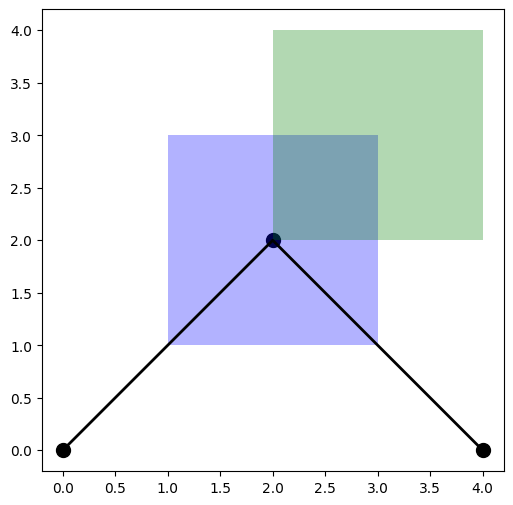

In [45]:
# Create plot with all existing geometries
ax = points_gs.plot(color='black', markersize=100, figsize=(6, 6))
polys_gs.plot(ax=ax, color=['blue', 'green'], alpha=0.3)
line_gs.plot(ax=ax, color='black', linewidth=2)


**Indexing**

Select subsets of geometries using various indexing methods.

In [47]:
print(f"Boolean indexing - points only: {points_gs[points_gs.geom_type == 'Point'].shape[0]} geometries\n")
print(f"First geometry in points_gs: {points_gs.iloc[0]}\n")
print(f"Last geometry in polys_gs: {polys_gs.iloc[-1]}\n")
print(f"Slice of points (first 2): {points_gs.iloc[:2].tolist()}\n")
print(f"Selected indices [0, 2] from points: {points_gs.iloc[[0, 2]].tolist()}\n")

Boolean indexing - points only: 3 geometries

First geometry in points_gs: POINT (0 0)

Last geometry in polys_gs: POLYGON ((2 2, 4 2, 4 4, 2 4, 2 2))

Slice of points (first 2): [<POINT (0 0)>, <POINT (2 2)>]

Selected indices [0, 2] from points: [<POINT (0 0)>, <POINT (4 0)>]



**Spacial indexing**

In [48]:
# Combine all existing geometries
all_geoms = gpd.GeoSeries(list(points_gs) + list(polys_gs) + list(line_gs))
sindex = all_geoms.sindex

# Query around point2
point2 = points_gs.iloc[1]
query_box = (point2.x - 0.5, point2.y - 0.5, point2.x + 0.5, point2.y + 0.5)
matches = list(sindex.intersection(query_box))
print(f"Geometries near point2: {len(matches)} matches at indices {matches}\n")

Geometries near point2: 4 matches at indices [np.int64(5), np.int64(1), np.int64(3), np.int64(4)]



**Interface**

Access geometry properties and perform common operations. 

In [49]:
print(f"X coordinates of points: {points_gs.x}\n")
print(f"Y coordinates of points: {points_gs.y}\n")
print(f"Centroids of polygons: {polys_gs.centroid.tolist()}\n")

# Use point2 as reference
point2 = points_gs.iloc[1]
print(f"Distances from all points to point2: {points_gs.distance(point2).tolist()}\n")

print(f"Bounds of polygons:\n{polys_gs.bounds}\n")
print(f"Representative points of polygons: {polys_gs.representative_point().tolist()}\n")

X coordinates of points: 0    0.0
1    2.0
2    4.0
dtype: float64

Y coordinates of points: 0    0.0
1    2.0
2    0.0
dtype: float64

Centroids of polygons: [<POINT (2 2)>, <POINT (3 3)>]

Distances from all points to point2: [2.8284271247461903, 0.0, 2.8284271247461903]

Bounds of polygons:
   minx  miny  maxx  maxy
0   1.0   1.0   3.0   3.0
1   2.0   2.0   4.0   4.0

Representative points of polygons: [<POINT (2 2)>, <POINT (3 3)>]



**Spatial index**

Used to speed up queries using an [R-tree](https://en.wikipedia.org/wiki/R-tree) index. 

#### GeoDataFrame

GeoDataFrame is the core data structure that extends the good old DataFrame with geometry columns. Just as GeoSeries is like a pandas Series with geometries, the GeoDataFrame is like a pandas DataFrame where there are one or more columns with geometries. 

Now we will genereete some new points to work with. 

In [ ]:
points_gs = gpd.GeoSeries.from_wkt([
    'POINT (-74.006 40.7128)',    # NYC
    'POINT (-0.1278 51.5074)',    # London
    'POINT (139.6917 35.6895)',   # Tokyo
    'POINT (151.2093 -33.8688)',  # Sydney
    'POINT (13.4050 52.5200)'     # Berlin
])

polygons_gs = gpd.GeoSeries.from_wkt([
    'POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))',
    'POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))',
    'POLYGON ((1 2, 2 2, 2 3, 1 3, 1 2))'
])

print(f"Points: {len(points_gs)} cities\n")
print(f"Polygons: {len(polygons_gs)} areas\n")

Points: 5 cities

Polygons: 3 areas



**Constructor**


**Serialization / IO / Conversion**

**Project handling**

#### In & Out

**GIS vector files**

**Post GIS**

**Feather**

**Parquet**

#### Tools 

#### Spacial index

#### Testing 

## Architecture and implementation

## Data handling

#### Data structures

#### Reading and writing files

#### Indexing and selecting data 

#### Merging data

#### Projections

## Geodata visualization

#### Making maps and plots

#### Interactive mapping

## Essential operations


#### Geometric manipulations

#### Setting operations with overlay 

#### Aggregation with dissolve

#### Sampling points

#### Geocoding

## Functionality

#### Simple real-life examples


#### Climate change & coastal flood risk modeling

## Interactive visualization with Kepler.gl

#### Brief introduction to Kepler



#### Climate change & the Artic Sea 

## References:


[GeoPandas 1.1.1](https://geopandas.org/en/stable/index.html)

https://kepler.gl/

Kelsey Jordahl, Joris Van den Bossche, Martin Fleischmann, Jacob Wasserman, James McBride, Jeffrey Gerard, … François Leblanc. (2020, July 15). geopandas/geopandas: v0.8.1 (Version v0.8.1). Zenodo. http://doi.org/10.5281/zenodo.3946761